## Цель иследования
 - выявить частоту (периоды) повторяемости наблюдаемой характеристики 'rang_namber'
 - создать модель для ML позволяющую предиктить периоды на новых данных 
 - предположить факторы влияющие на чатсоту повторяемости
 - https://github.com/julianandrews/flopferret/blob/master/flopferret/board_texture.py

In [151]:
!pip install cached_property

In [2]:
import re
import pandas as pd
from datetime import datetime
import eval7, pprint
from poker.room.pokerstars import PokerStarsHandHistory
from poker.hand import Hand, Combo
import numpy as np
from phevaluator import evaluate_cards
import matplotlib.pyplot as plt
plt.style.use('dark_background') #стиль графиков

In [153]:
# Создали словарь
data_pd = {'TypeOfRoom': [], 'HandId': [], 'Tournament': [], 'Level': [], 'Date': [], 'Hour': [],
           'TimeZoneAbb': [], 'Table': [], 'NoOfPlayers': [], 'bain': [], 'HandHiro': [], 'Board': []}

# Открываем файл
with open('Poker_\SNG dimetruk 1-54133.txt', 'r') as f: # dim1000.txt
    data = f.read()
    
# Ищем нужные данные
result = re.findall('(\w+) Hand #(\d*): Tournament #(\d*),(.*) Level (.*) - (\d{4}/\d+/\d+) (\d+\D\d+\D\d+) (\w*)', data)
Tables = re.findall('Table \'.*\' (.*) Seat .*\n', data)
bains = re.findall('(\D\d+\.\d+\+\D\d+\.\d+)', data)
HandHiros = re.findall("Dealt to dimetruk \D(.. ..)\D", data)
Boards = re.findall("Board \[(.*)\]", data)


# Считаем сколко фишек
s = re.findall('Seat (\d).*chips', data)
s = [int(x) for x in s]
seats = []
length = 1
for i in range(len(s)-1):
    if s[i+1] < s[i]:
        seats.append(length)
        length = 1
    else:
        length += 1
seats.append(length)


# ЗАполнЯем словарь данными
for r, table, bain, seat, handHiro, board in zip(result, Tables, bains, seats, HandHiros, Boards):
    data_pd['TypeOfRoom'].append(r[0])
    data_pd['HandId'].append(r[1])
    data_pd['Tournament'].append(r[2])
    # data_pd['info'].append(r[3])
    data_pd['Level'].append(r[4])
    data_pd['Date'].append(r[5])
    data_pd['Hour'].append(r[6])
    data_pd['TimeZoneAbb'].append(r[7])
    data_pd['Table'].append(table) #table
    data_pd['NoOfPlayers'].append(seat)
    data_pd['bain'].append(bain)
    data_pd['HandHiro'].append(handHiro)
    data_pd['Board'].append(board)

# Создаём ДатаФрейм
dataf = pd.DataFrame(data_pd)
dataf.head()

,TypeOfRoom,HandId,Tournament,Level,Date,Hour,TimeZoneAbb,Table,NoOfPlayers,bain,HandHiro,Board
0,PokerStars,189303406555,2369603774,IV (40/80),2018/07/30,0:01:30,MSK,9-max,6,$13.70+$1.30,Qh 6h,8h 7d 2h 8c 4s
1,PokerStars,189303615886,2369603774,V (60/120),2018/07/30,0:05:40,MSK,9-max,6,$13.70+$1.30,Qc Td,Qh 5h Js Kd
2,PokerStars,189303670340,2369603774,V (60/120),2018/07/30,0:06:42,MSK,9-max,6,$13.70+$1.30,Ac 7d,2d Ad Ah Js 6s
3,PokerStars,189303726585,2369603774,V (60/120),2018/07/30,0:07:47,MSK,9-max,6,$13.70+$1.30,Tc Qc,Td 5h 2c 5d Kd
4,PokerStars,189303781865,2369603774,V (60/120),2018/07/30,0:08:51,MSK,9-max,6,$13.70+$1.30,Qs 5d,9s 7h Jh 8h 9d


## Преобразуем строковые данные

In [154]:
date = data_pd['Date']
time = data_pd['Hour']

dataf["Date"] = pd.to_datetime(data_pd['Date'])
dataf["Time"] = pd.to_timedelta(data_pd['Hour'])

dataf["DateTime"] = dataf["Date"] + dataf["Time"]
dataf["DateTime"]

# filter by single day
dataf_m = dataf[dataf['DateTime'].dt.strftime('%d') == '06']

dataf.Tournament = dataf.Tournament.astype('int64')
dataf = dataf.astype({'HandId': np.int64, 'Tournament': np.int64})

In [155]:
dataf_m

,TypeOfRoom,HandId,Tournament,Level,Date,Hour,TimeZoneAbb,Table,NoOfPlayers,bain,HandHiro,Board,Time,DateTime
10639,PokerStars,190718126222,2399916882,I (10/20),2018-09-06,8:27:00,MSK,6-max,6,$3.13+$0.37,Ts 5h,7h 8h Ad,0 days 08:27:00,2018-09-06 08:27:00
10640,PokerStars,190718137542,2399916882,I (10/20),2018-09-06,8:27:55,MSK,6-max,6,$3.13+$0.37,Th 6c,7d Qd 6s,0 days 08:27:55,2018-09-06 08:27:55
10641,PokerStars,190718144654,2399916882,I (10/20),2018-09-06,8:28:29,MSK,6-max,6,$3.13+$0.37,Ah 9d,3c 8s 5c 5s Qd,0 days 08:28:29,2018-09-06 08:28:29
10642,PokerStars,190718159213,2399916882,I (10/20),2018-09-06,8:29:39,MSK,6-max,6,$3.13+$0.37,Td 2h,9s 7d 7h Qc Th,0 days 08:29:39,2018-09-06 08:29:39
10643,PokerStars,190718178532,2399916882,I (10/20),2018-09-06,8:31:13,MSK,6-max,6,$3.13+$0.37,4s Qh,3s Kc 5s 5c Jh,0 days 08:31:13,2018-09-06 08:31:13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34168,PokerStars,191869580938,2424715320,IV (40/80),2018-10-06,17:57:06,MSK,9-max,6,$6.37+$0.63,Js Td,6h Jh 4h Ts 9d,0 days 17:57:06,2018-10-06 17:57:06
34169,PokerStars,191869592342,2424715320,IV (40/80),2018-10-06,17:57:31,MSK,9-max,6,$6.37+$0.63,7h 6d,Jd Ts 8h 2c 8c,0 days 17:57:31,2018-10-06 17:57:31
34170,PokerStars,191869625613,2424715320,IV (40/80),2018-10-06,17:58:44,MSK,9-max,6,$6.37+$0.63,Jh Tc,6d 5s 3h Qd As,0 days 17:58:44,2018-10-06 17:58:44
34171,PokerStars,191869640756,2424715320,IV (40/80),2018-10-06,17:59:16,MSK,9-max,6,$6.37+$0.63,Kh 7c,6d 6h Kc 7d 2c,0 days 17:59:16,2018-10-06 17:59:16


In [156]:
nov_mar_series = pd.Series(pd.date_range("2013-11-15", "2014-03-15"))
#create timestamp without year
nov_mar_no_year = nov_mar_series.map(lambda x: x.strftime("%m-%d"))
nov_mar_no_year

0      11-15
1      11-16
2      11-17
3      11-18
4      11-19
       ...  
116    03-11
117    03-12
118    03-13
119    03-14
120    03-15
Length: 121, dtype: object

In [157]:
# #add a yearless timestamp to the dataframe
# df["no_year"] = df['nov_mar_series'].map(lambda x: x.strftime("%m-%d"))
# no_year_mask = df['no_year'].isin(nov_mar_no_year)
# df[no_year_mask]

## Фильтруем турниры по числу рук выше среднего (> mean)

In [158]:
data_filter = dataf[['Tournament', 'HandId','DateTime', 'Time', 'HandHiro', 'Board']]
data_filter.head()

,Tournament,HandId,DateTime,Time,HandHiro,Board
0,2369603774,189303406555,2018-07-30 00:01:30,0 days 00:01:30,Qh 6h,8h 7d 2h 8c 4s
1,2369603774,189303615886,2018-07-30 00:05:40,0 days 00:05:40,Qc Td,Qh 5h Js Kd
2,2369603774,189303670340,2018-07-30 00:06:42,0 days 00:06:42,Ac 7d,2d Ad Ah Js 6s
3,2369603774,189303726585,2018-07-30 00:07:47,0 days 00:07:47,Tc Qc,Td 5h 2c 5d Kd
4,2369603774,189303781865,2018-07-30 00:08:51,0 days 00:08:51,Qs 5d,9s 7h Jh 8h 9d


In [159]:
# data_filter.groupby(['Tournament']).agg({'HandId': "count"}).reset_index()

In [160]:
#  Фильтруйте value_counts с помощью isin  https://softhints.com/pandas-how-to-filter-results-of-value_counts/
df = data_filter[data_filter['Tournament'].isin(data_filter['Tournament'].
                                                 value_counts()[data_filter['Tournament'].value_counts()>100].index)]
df

,Tournament,HandId,DateTime,Time,HandHiro,Board
593,2376756155,189630702725,2018-08-07 22:22:20,0 days 22:22:20,4h 8c,7s 6h 7d 7h Qh
594,2376756155,189630765334,2018-08-07 22:23:52,0 days 22:23:52,Ac Td,Jh 7c 4s
595,2376756155,189630831791,2018-08-07 22:25:31,0 days 22:25:31,6s 9s,8d 8s 9d 7s 2h
596,2376756155,189630879488,2018-08-07 22:26:42,0 days 22:26:42,Ks 3s,2h Jh Jc
597,2376756155,189630930089,2018-08-07 22:27:56,0 days 22:27:56,2d Jc,Td Qs Ac 7h 7c
...,...,...,...,...,...,...
52793,2443486128,192754299389,2018-10-30 14:10:47,0 days 14:10:47,Th 7s,2d 8c As
52794,2443486128,192754313910,2018-10-30 14:11:30,0 days 14:11:30,8c 2c,8d 8s Kc Td
52795,2443486128,192754323670,2018-10-30 14:11:59,0 days 14:11:59,Js 6s,5h 9c 4h
52796,2443486128,192754327821,2018-10-30 14:12:12,0 days 14:12:12,2s Qs,Ts 4c 9h


In [161]:
#  Используйте group by и lambda для имитации фильтра для value_counts()
#df = data_filter.groupby('Tournament').filter(lambda x: len(x) > (data_filter['Tournament'].value_counts().mean()))


In [162]:
df.Tournament.value_counts()

2428056269    141
2428490625    123
2441088093    121
2437236305    116
2421274457    111
2424624408    109
2376756155    106
2406092557    106
2395127346    104
2415654063    103
2401643232    102
2443486128    102
2400001613    101
2438757352    101
Name: Tournament, dtype: int64

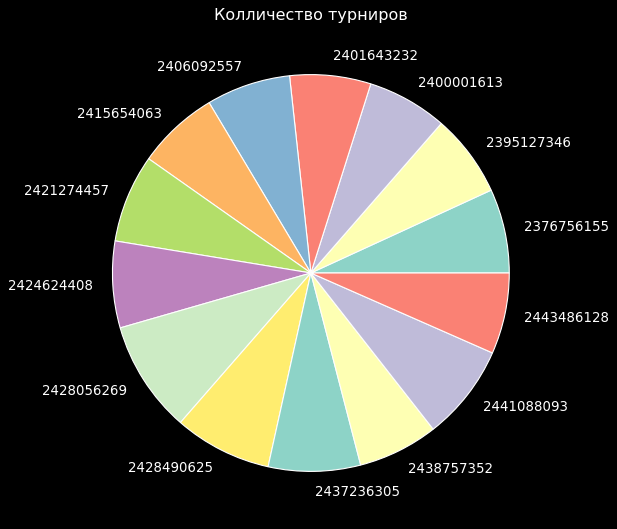

In [118]:
# Prepare Data
df_plot = df.groupby('Tournament').size()

# Make the plot with pandas
df_plot.plot(kind='pie', subplots=True, figsize=(8, 8))
plt.title("Колличество турниров")
plt.ylabel("")
plt.show()

In [119]:
# объеденяем руку и борд, выводим название комбинации

# df['hand'] = df['HandHiro'] + " " + df['Board']
# # hand = df['hand'].values[7].split()
# # print(hand)

# hand_ev = [eval7.Card(s) for s in (df['hand'].values[7].split())]
# rang = eval7.evaluate(hand_ev)   # ранг комбинации
# # print(rang)

# eval7s = eval7.handtype(rang)  #  название комбинации

# df['rang'] = eval7.evaluate(hand_ev)
# df['eval7s'] =  eval7.handtype(rang)

In [120]:
# def new_type(row):
#     if row.traffic_source.lower() in ('yandex', 'google'):
#         return 'organic'
#     elif row.traffic_source.lower() in ('paid', 'email'):
#         if row.region.lower() == 'russia':
#             return 'ad'
#         else:
#             return 'other'

In [121]:
# log['source_type'] = log.apply(new_type, axis = 1)
# log.head(12)

In [122]:
# log.loc[log.traffic_source.isin(['yandex', 'google']), 'traffic_type'] = 'organic' 

In [123]:
df['hand_rang'] = df['HandHiro'] + " " + df['Board']
df['hand_rang']

print(type(df['hand_rang']), type(df['hand_rang'].values[7].split()))
df['hand_rang'].values[0].split()

<class 'pandas.core.series.Series'> <class 'list'>


C:\Users\artio\AppData\Local\Temp\ipykernel_33228\2709538268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hand_rang'] = df['HandHiro'] + " " + df['Board']


['4h', '8c', '7s', '6h', '7d', '7h', 'Qh']

In [124]:
# df['hand_rang'].to_list()
# df['hand_rang'].tolist()
# np.array(df['hand_rang'].tolist())
# Ls = list(df['hand_rang'])
ls = df['hand_rang'].str.split()
ls

593      [4h, 8c, 7s, 6h, 7d, 7h, Qh]
594              [Ac, Td, Jh, 7c, 4s]
595      [6s, 9s, 8d, 8s, 9d, 7s, 2h]
596              [Ks, 3s, 2h, Jh, Jc]
597      [2d, Jc, Td, Qs, Ac, 7h, 7c]
                     ...             
52793            [Th, 7s, 2d, 8c, As]
52794        [8c, 2c, 8d, 8s, Kc, Td]
52795            [Js, 6s, 5h, 9c, 4h]
52796            [2s, Qs, Ts, 4c, 9h]
52797    [Th, Kc, 6c, Qc, 3d, Js, 5s]
Name: hand_rang, Length: 1546, dtype: object

In [3]:
# напишем функцию получения ранг комбинации

def evaluate_(hand):
    """
    На вход получает карты, на выход 
    число ранг по eval7
    """
    hand_ev = [eval7.Card(s) for s in (hand)]
    return eval7.evaluate(hand_ev),hand_ev

a = ('Jh', 'Td', '8h', '8c', '7c', '3h', '6d')
evaluate_(a)

(17209424,
 [Card("Jh"),
  Card("Td"),
  Card("8h"),
  Card("8c"),
  Card("7c"),
  Card("3h"),
  Card("6d")])

In [126]:
# напишем функцию получения названия ранга

def handtype_(rang):
    """
    На вход получает ранг, на выход 
    название комбинации
    """
    return eval7.handtype(rang)

handtype_(17209424)

'Pair'

In [127]:
# Применим функцию к столбцу hand  и запишем в новый столбец rang_namber

df['rang_namber'] = df['hand_rang'].str.split().apply(evaluate_)
df['handtypes'] = df['rang_namber'].apply(handtype_)
df[['rang_namber', 'handtypes','HandHiro', 'Board']].head(20)
# df['filter'] = df.loc[df.handtypes.str.contains('Two Pair', 'Trips', 'Straight', 'Full House', 'Quads', 'Straight Flush'), 'rang_namber']

C:\Users\artio\AppData\Local\Temp\ipykernel_33228\679876584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rang_namber'] = df['hand_rang'].str.split().apply(evaluate_)
C:\Users\artio\AppData\Local\Temp\ipykernel_33228\679876584.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['handtypes'] = df['rang_namber'].apply(handtype_)


,rang_namber,handtypes,HandHiro,Board
593,50701824,Trips,4h 8c,7s 6h 7d 7h Qh
594,825426,High Card,Ac Td,Jh 7c 4s
595,34039040,Two Pair,6s 9s,8d 8s 9d 7s 2h
596,17412352,Pair,Ks 3s,2h Jh Jc
597,17156752,Pair,2d Jc,Td Qs Ac 7h 7c
598,16828784,Pair,Js 2s,9h 8s 2d Ac 5c
599,16894048,Pair,3c 6d,Th 8c 3s Ah 5c
600,101462016,Full House,5c Ah,Qd 8h As Ad 5s
601,67895296,Straight,Th Jd,2d Ac Kd Qd 2h
602,17348432,Pair,Kc 5s,7c Ts 4s Tc 9s


In [128]:
# df.sort_values(by=['handtypes', 'rang_namber'])

In [129]:
# df.groupby('handtypes')['rang_namber'].value_counts()

### Создадим сводную таблицу, что-бы проверить наличие аномалий

In [130]:
# filter by single day
dataf_m = dataf[dataf['DateTime'].dt.strftime('%d') == '06']

In [131]:
df[['Tournament', 'handtypes', 'rang_namber']].head()  # применим фильтер по столбцам

,Tournament,handtypes,rang_namber
593,2376756155,Trips,50701824
594,2376756155,High Card,825426
595,2376756155,Two Pair,34039040
596,2376756155,Pair,17412352
597,2376756155,Pair,17156752


In [132]:
pd.pivot_table(df, index=["Tournament", "handtypes"])

HandId   rang_namber
Tournament handtypes                             
2376756155 Flush       1.896335e+11  8.465007e+07
           Full House  1.896327e+11  1.011073e+08
           High Card   1.896327e+11  7.829009e+05
           Pair        1.896327e+11  1.722032e+07
           Straight    1.896329e+11  6.763315e+07
...                             ...           ...
2443486128 High Card   1.927539e+11  7.533628e+05
           Pair        1.927538e+11  1.717030e+07
           Straight    1.927541e+11  6.761677e+07
           Trips       1.927543e+11  5.077197e+07
           Two Pair    1.927539e+11  3.411114e+07

[97 rows x 2 columns]

In [133]:
# явно определив столбцы, которые нам нужны,
pd.pivot_table(df,
               index=["Tournament", "handtypes"],
               values=["rang_namber"],
               aggfunc= len)   # aggfunc=[np.mean, len])

rang_namber
Tournament handtypes              
2376756155 Flush                 1
           Full House            5
           High Card            22
           Pair                 54
           Straight              6
...                            ...
2443486128 High Card            34
           Pair                 42
           Straight              4
           Trips                 1
           Two Pair             17

[97 rows x 1 columns]

In [134]:
df.Tournament.value_counts()

2428056269    141
2428490625    123
2441088093    121
2437236305    116
2421274457    111
2424624408    109
2376756155    106
2406092557    106
2395127346    104
2415654063    103
2401643232    102
2443486128    102
2400001613    101
2438757352    101
Name: Tournament, dtype: int64

In [135]:
# df['Time'].value_counts()

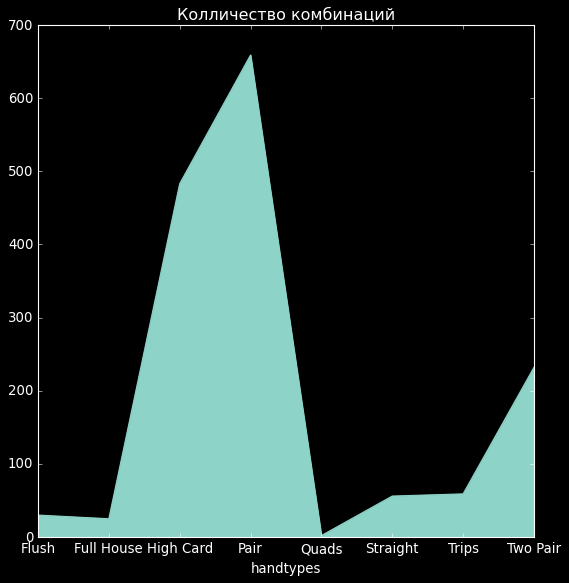

In [136]:
# Prepare Data
df_plot = df.groupby('handtypes').size()

# Make the plot with pandas
df_plot.plot(kind='area', subplots=True, figsize=(8, 8))
plt.title("Колличество комбинаций")
plt.ylabel("")
plt.show()

In [137]:
# df['DateTime'] = df['DateTime'][(df['DateTime'] > '2018-10-01 20:00:00') & (df['DateTime'] < '2022-10-02 00:00:00')]
# df['DateTime']


In [138]:
# отфильтруем комбинации "старшая карта" и "пара"
df['no_par'] = df['rang_namber'][df['rang_namber'] > 50000000] #[((df['rang_namber'] > 50000000) & (df['rang_namber'] < 60000000))]
df = df.dropna()
df[['Time', 'no_par', 'handtypes']].head(10)
# df['filter_Two Pair'] = df['handtypes'][df['handtypes'] == 'Two Pair']
# df['filter_Two Pair']

C:\Users\artio\AppData\Local\Temp\ipykernel_33228\446220528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no_par'] = df['rang_namber'][df['rang_namber'] > 50000000] #[((df['rang_namber'] > 50000000) & (df['rang_namber'] < 60000000))]


,Time,no_par,handtypes
593,0 days 22:22:20,50701824.0,Trips
600,0 days 22:30:28,101462016.0,Full House
601,0 days 22:31:51,67895296.0,Straight
619,0 days 22:50:10,101130240.0,Full House
633,0 days 23:09:42,50492672.0,Trips
639,0 days 23:13:22,67502080.0,Straight
642,0 days 23:15:44,50973184.0,Trips
650,0 days 23:19:35,101122048.0,Full House
651,0 days 23:19:54,67567616.0,Straight
657,0 days 23:22:59,50775296.0,Trips


In [139]:
df.isnull().sum()

Tournament     0
HandId         0
DateTime       0
Time           0
HandHiro       0
Board          0
hand_rang      0
rang_namber    0
handtypes      0
no_par         0
dtype: int64

In [140]:
# преобразуем время во временной ряд

In [141]:


idx = df['Time']
 # datetime.timedelta(seconds=24*60*60).total_seconds()

# second = df['DateTime'].dt.total_seconds()
# second

# idx = pd.date_range(df['DateTime'], periods=5, freq="H")
# idx
tim = pd.Series(range(len(idx)), index=idx)

# ts.resample("2H").mean()
tim

Time
0 days 22:22:20      0
0 days 22:30:28      1
0 days 22:31:51      2
0 days 22:50:10      3
0 days 23:09:42      4
                  ... 
0 days 13:58:07    167
0 days 13:59:43    168
0 days 14:00:44    169
0 days 14:06:44    170
0 days 14:11:30    171
Length: 172, dtype: int64

In [142]:
# df = df.set_index("Time")
# df

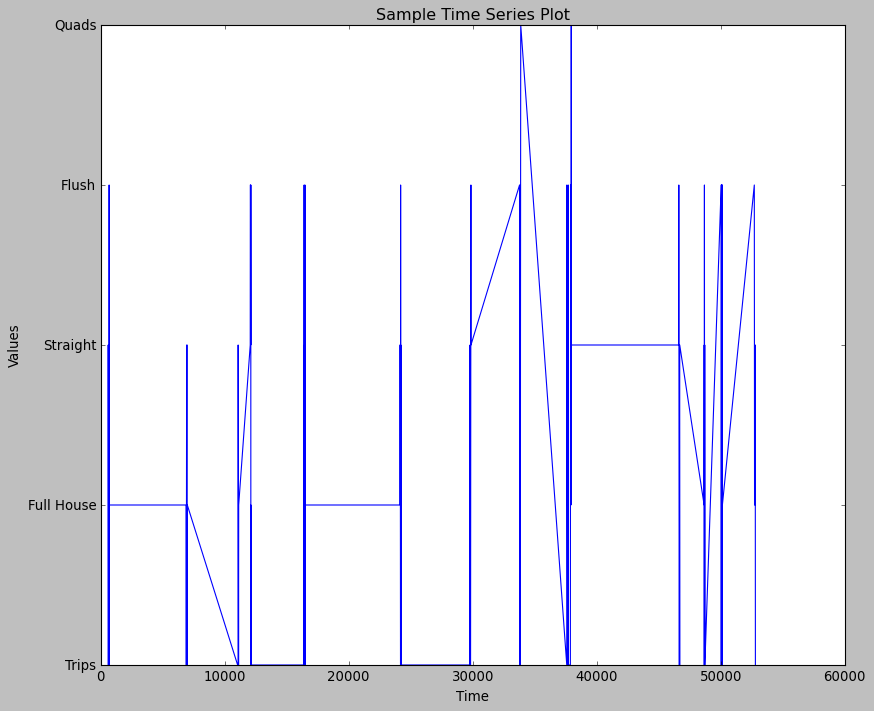

In [143]:

import matplotlib.pyplot as plt
 
# Using a inbuilt style to change
# the look and feel of the plot
plt.style.use("classic")
 
# setting figure size to 12, 10
plt.figure(figsize=(12, 10))
 
# Labelling the axes and setting
# a title
plt.xlabel("Time")
plt.ylabel("Values")
plt.title("Sample Time Series Plot")
 
# plotting the "A" column alone
plt.plot(df["handtypes"])

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

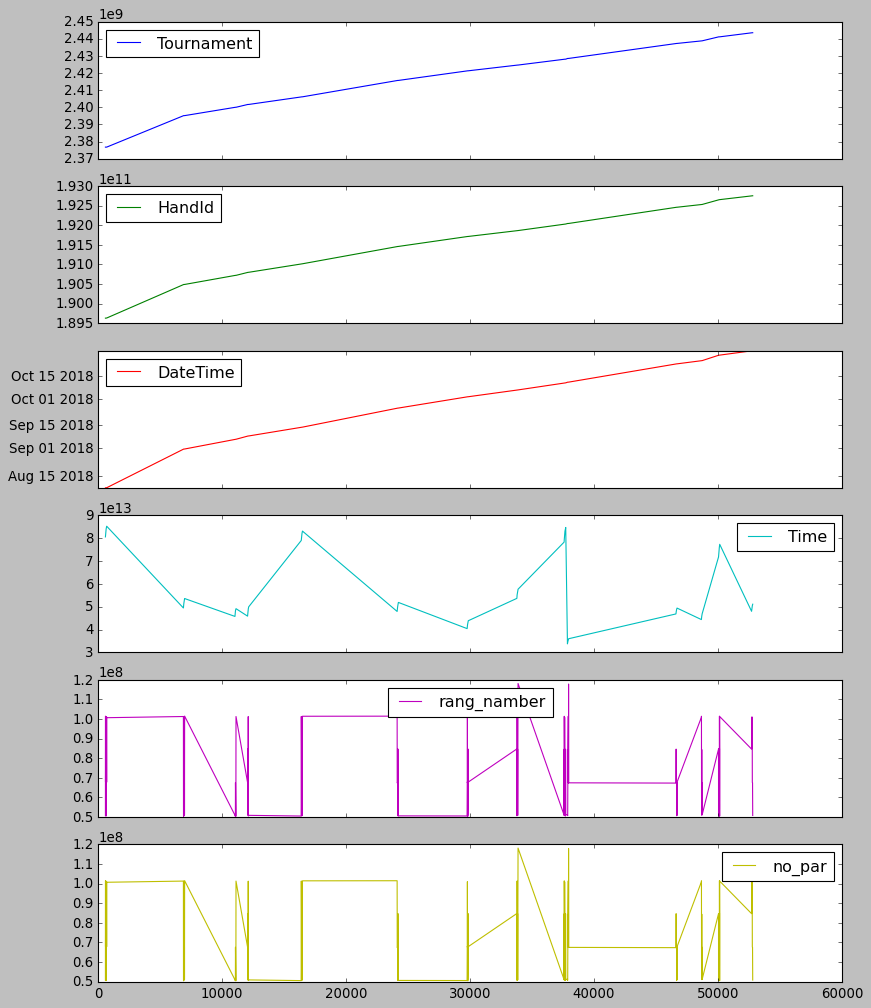

In [144]:
df.plot(subplots=True, figsize=(12, 15))

In [145]:
# # # idx = pd.date_range('2019-01-01', periods=48, freq='H')
# # x = pd.Series(range(len(idx)), index=idx)
# y = tim
# # add 'hour' and 'day' columns in the dataframe
# d = {'x': x, 'y': y, 'hour': idx.hour, 'day': idx.day}
# df = pd.DataFrame(data=d)
# # use 'hour' as x axis to plot, and 'day' as marker color
# df.plot.scatter(x='hour', y='y', c='day', colormap='rainbow')
# plt.show()

In [146]:
data.dtypes

AttributeError: 'str' object has no attribute 'dtypes'

In [ ]:
# установитьdatetimeОбъект в качестве индекса кадра данных
data = data.set_index('DateTime')
data.head()

In [ ]:

# data.plot(grid=True)

data['filter'].plot(kind='bar')

# import matplotlib.pyplot as plt
# from matplotlib.dates import DateFormatter
# # Группировка за месяц
# df_month = data.resample("M").mean()

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
# ax.bar(
#     df_month['2018':].index, 
#     df_month.loc['2016':, "filter"], 
#     width=25, align='center')

In [ ]:

data.plot(kind='scatter', 
        x='DateTime', 
        y='filter', 
        title='Связь между жёсткостью воды и средней годовой смертностью')